In [39]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import pickle
import sys
from sys import exc_info
import ast
from matplotlib import pyplot as plt
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from google.colab import drive
drive.mount('/content/drive/')

speech_path = "/content/drive/MyDrive/Data/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [40]:
df_all = pd.read_csv(speech_path + "KaDo.csv")

In [41]:
# taking only a part of rows for trainning
df = df_all[:100000]
unique, counts = np.unique(df["CLI_ID"].unique(), return_counts=True)
print(f"Number of clients {len(unique)}")
df = df.reset_index() 
df

Number of clients 7506


,index,TICKET_ID,MOIS_VENTE,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE,CLI_ID
0,0,35592159,10,1.67,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
1,1,35592159,10,1.66,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
2,2,35592159,10,7.45,SOINS DU VISAGE,VIS_CJOUR Jeunes Specifique,VIS_JEUNE_ET_LEVRE,CR JR PARF BIO.SPE AC.SENT.50ML,1490281
3,3,35592159,10,5.95,SOINS DU VISAGE,VIS_DEMAQ AAAR,VIS_AAAR_DEMAQLOTION,EAU MICELLAIRE 3 THES FL200ML,1490281
4,4,35592159,10,1.67,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 TIARE FL 200ML,1490281
...,...,...,...,...,...,...,...,...,...
99995,99995,35867086,11,4.95,SOINS DU CORPS,CORPS_HYDRA NOURRISANT,CORPS_HYDRA_NOURRI_ET_SOINS,LAIT REPARATEUR KARITE 150ML,932318780
99996,99996,33184092,1,3.95,MAQUILLAGE,MAQ_YEUX Crayons,MAQ_YEUX_CLASSIQUE,CRAYON REGARD NOIR CN3 1.3G,932319384
99997,99997,33184092,1,8.95,MAQUILLAGE,MAQ_YEUX Mascara Specifique,MAQ_YEUX_MASCA_EYEL_FARD,MASCARA DEPLOYE NOIR 01 CN3 9ML,932319384
99998,99998,33184092,1,3.00,MAQUILLAGE,MAQ_LEV BRILLANT,MAQ_LEV_BASPRIX,"GLOSS CORAIL/TEND IT/COL AOUT13 L4 4,5ML",932319384


In [42]:
# Encode libelles so we can use them in our algorithms 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['UNIVERS'])
print('Number of UNIVERS is:', len(le.classes_))

univers_encoded = le.transform(df['UNIVERS'])
df['UNIVERS_ENCODED'] = univers_encoded

# Save encoded libelles into csv file
carts_encoded = df.drop(['UNIVERS'], axis=1)

Number of UNIVERS is: 97


In [54]:
clients = df["CLI_ID"].unique()

# return an array containning all libelle by client
def libelleListByClients(clients, data):
    client_univers_list = []
    client_id_passed = []
    for client in clients:
        client_univers_list.append(str(list(data[data['CLI_ID'] == client]['UNIVERS_ENCODED'])).split('[')[1].split(']')[0])
    return client_univers_list

clients_univers_list = libelleListByClients(clients, df)
# clients_univers_list

In [44]:
# SPARE MATRIX
def prepSparseMatrix(list_of_str):
    # list_of_str = A list, which contain strings of users favourite movies separate by comma ",".
    # It will return us sparse matrix and feature names on which sparse matrix is defined 
    # i.e. name of movies in the same order as the column of sparse matrix
    cv = CountVectorizer(token_pattern = r'[^\,\ ]+', lowercase = False)
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix.toarray(), cv.get_feature_names()

In [45]:
sparseMatrix, feature_names = prepSparseMatrix(clients_univers_list)
df_sparseMatrix = pd.DataFrame(sparseMatrix, index = clients, columns = feature_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()
    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b = True)
        plt.subplot(122).set_title('Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()

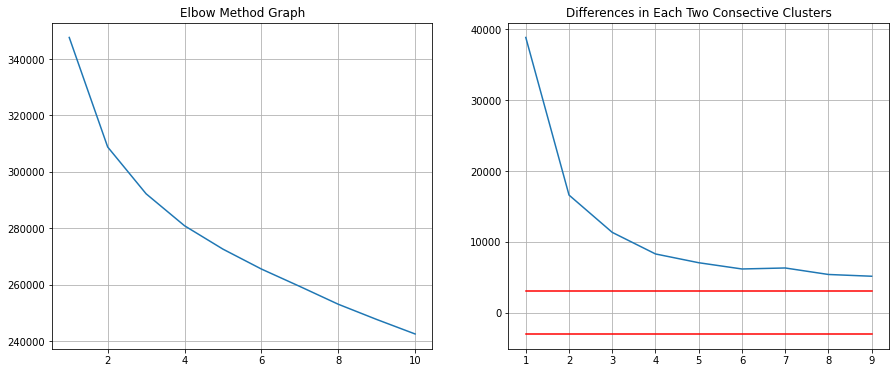

In [47]:
# Instantiate elbowMethod with our SM
elbow_method = elbowMethod(sparseMatrix) 
# Test SM with several K
elbow_method.run(1, 10)
elbow_method.showPlot(boundary = 3000)

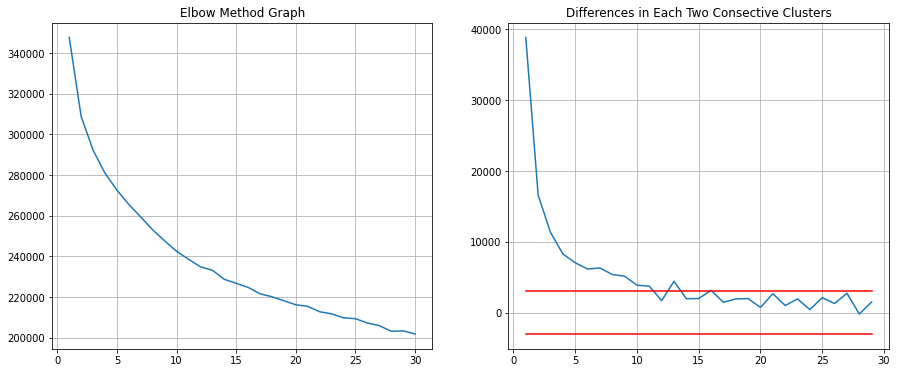

In [48]:
elbow_method.run(11, 30)
elbow_method.showPlot(boundary = 3000)

In [49]:
kmeans = KMeans(n_clusters=12, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(sparseMatrix)

In [50]:
client_cluster = pd.DataFrame(np.concatenate((clients.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['clientId', 'Cluster'])
client_cluster.T

,0,1,2,3,4,5,6,7,8,9,...,7496,7497,7498,7499,7500,7501,7502,7503,7504,7505
clientId,1490281,13290776,20163348,20200041,20561854,20727324,20791601,21046542,21239163,21351166,...,932306331,932306612,932306959,932308955,932309896,932314153,932316025,932316372,932318780,932319384
Cluster,1,3,3,3,3,3,3,3,1,3,...,2,3,3,11,3,2,3,3,3,3


In [60]:
def clustersMovies(client_cluster, univer_data):
    clustersUnivers = list(client_cluster['Cluster'])
    each_cluster_univers = list()
    for i in range(len(np.unique(clusters))):
        clients_list = list(client_cluster[client_cluster['Cluster'] == i]['clientId'])
        client_univers_list = list()
        for client in clients_list:    
            client_univers_list.extend(list(univer_data[univer_data['CLI_ID'] == client]['UNIVERS_ENCODED']))
        client_univers_counts = list()
        client_univers_counts.extend([[movie, client_univers_list.count(movie)] for movie in np.unique(client_univers_list)])
        each_cluster_univers.append(pd.DataFrame(client_univers_counts, columns=['univerId', 'Count']).sort_values(by = ['Count'], ascending = False).reset_index(drop=True))
    return each_cluster_univers
cluster_univers = clustersMovies(client_cluster, df)


In [61]:
# For cluster 1, libelle [LIBELLE_ENCODED] is present [Count] times
cluster_univers[1].T

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
univerId,30,33,15,35,73,16,32,9,21,45,...,7,89,65,17,54,6,81,36,83,80
Count,3181,405,350,326,275,269,264,262,238,224,...,8,8,7,6,5,3,3,3,1,1


In [64]:
for i in range(12):
    len_users = client_cluster[client_cluster['Cluster'] == i].shape[0]
    print('Client in Cluster ' + str(i) + ' -> ', len_users) 

Client in Cluster 0 ->  279
Client in Cluster 1 ->  721
Client in Cluster 2 ->  891
Client in Cluster 3 ->  4229
Client in Cluster 4 ->  201
Client in Cluster 5 ->  21
Client in Cluster 6 ->  200
Client in Cluster 7 ->  133
Client in Cluster 8 ->  209
Client in Cluster 9 ->  187
Client in Cluster 10 ->  127
Client in Cluster 11 ->  308
